In [1]:
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

# OOP Extended and super()

In [2]:
class SimpleClass():
    def __init__(self, str_input):
        print('SIMPLE ' + str_input)

In [3]:
class ExtendedClass(SimpleClass):
    def __init__(self):
        super().__init__('Dang Khoa')
        print('EXTENDED')

In [4]:
s = ExtendedClass()

SIMPLE Dang Khoa
EXTENDED


# Manual Tensorflow

### Operations

In [5]:
class Operation():
    """
    An Operation is a node in a "Graph". TensorFlow will also use this concept of a Graph.
    
    This Operation class will be inherited by other classes that actually compute the specific
    operation, such as adding or matrix multiplication.
    """
    def __init__(self, input_nodes = []):
        self.input_nodes = input_nodes # The list of input nodes
        self.output_nodes = [] # List of nodes consuming this node's output

        # For every node in the input, we append this operation (self) to the list of
        # the consumers of the input nodes
        for node in input_nodes:
            node.output_nodes.append(self)

        # There will be a global default graph (TensorFlow works this way)
        # We will then append this particular operation
        # Append this operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)

    def compute(self):
        """ 
        This is a placeholder function. It will be overwritten by the actual specific operation
        that inherits from this class.
        
        """
        pass

In [6]:
class add(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])

    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var


class multiply(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])

    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var * y_var


class matmul(Operation):
    '''Matrix Multiplication'''
    def __init__(self, x, y):
        super().__init__([x, y])

    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var.dot(y_var)


class Sigmoid(Operation):
    def __init__(self, z):
        super().__init__([z])

    def compute(self, z_val):
        return 1 / (1+np.exp(-z_val))

### Placeholders and Variables

In [7]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a value for computing the output in the Graph.
    """
    def __init__(self):
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)

In [8]:
class Variable():
    """
    This variable is a changeable parameter of the Graph.
    """
    def __init__(self, initial_value=None):
        self.value = initial_value
        self.output_nodes = []

        _default_graph.variables.append(self)

### Graph

In [9]:
class Graph():
    def __init__(self):
        self.operations = []
        self.placeholders = []
        self.variables = []

    def set_as_default(self):
        """
        Sets this Graph instance as the Global Default Graph
        """
        global _default_graph

        _default_graph = self

### Session

In [10]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b). Feel free to copy and paste this code.
    It is not super important for understanding the basic fundamentals of deep learning.
    """
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

In [11]:
class Session:
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to input values (the data)  
        """
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        for node in nodes_postorder:
            if type(node) == Placeholder:
                node.output = feed_dict[node]
            elif type(node) == Variable:
                node.output = node.value
            else: # Operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)

            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)

        # Return the requested node value
        return operation.output

### Example

$$ z = Ax + b $$
- A = 10
- b = 1
- Evaluate x = 10

In [12]:
# Graph
g = Graph()
g.set_as_default()

In [13]:
# Variables
A = Variable(10)
b = Variable(1)

# Placeholders
x = Placeholder()

In [14]:
# Operations
y = multiply(A,x)
z = add(y,b)

In [15]:
# Session
sess = Session()
result = sess.run(
    operation=z,
    feed_dict={x:10})

result

101

$$ z = Ax + b $$

- A = 
\begin{bmatrix}
    10 & 20 \\
    30 & 40
\end{bmatrix}
- b = 
\begin{bmatrix}
    1 & 1
\end{bmatrix}
- Evaluate x = 10

In [16]:
# Graph
g = Graph()
g.set_as_default()

In [17]:
# Variables
A = Variable([[10,20], [30,40]])
b = Variable([1,1])

# Placeholders
x = Placeholder()

In [18]:
# Operations
y = matmul(A,x)
z = add(y,b)

In [19]:
# Session
sess = Session()
result = sess.run(
    operation=z,
    feed_dict={x:10})

result

array([[101, 201],
       [301, 401]])

# Manual Classification

### Dataset

In [20]:
from sklearn.datasets import make_blobs

data = make_blobs(n_samples = 50,n_features=2,centers=2,random_state=75)

X = data[0]
y = data[1]

display(X.shape)
display(y.shape)

(50, 2)

(50,)

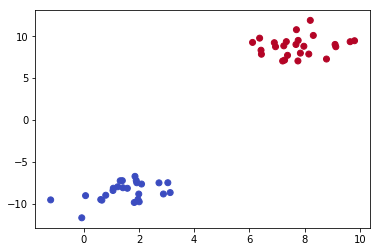

In [21]:
plt.scatter(
    x=X[:,0], y=X[:,1],
    c=y, cmap='coolwarm');

## Model
$$z=w^Tx+b$$
$$a=sigmoid(z)$$

In [22]:
# Graph
g = Graph()
g.set_as_default()

In [23]:
# Variables
w = Variable([1,1])
b = Variable(-5)

# Placeholders
x = Placeholder()

In [24]:
# Operations
z = add(matmul(w,x),b)
a = Sigmoid(z)

In [25]:
# Session
sess = Session()

# x = [8,10]
sess.run(
    operation=a,
    feed_dict={x:[8,10]})

0.999997739675702

In [26]:
# x = [0,-10]
sess.run(
    operation=a,
    feed_dict={x:[0,-10]})

3.059022269256247e-07